# Import Library

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import os

# Load Dataset

In [17]:
image_path = "../Latihan-2-Bear/Dataset/"

images = []

for filename in os.listdir(image_path):
    img = tf.keras.preprocessing.image.load_img(f"{image_path}{filename}", target_size=(64, 64))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)

# Preprocessing

In [18]:
# Preprocessing
images = np.asarray(images)

# Shuffle
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]

# Normalize
images = images.astype(np.float32) / 255.0

# Split Dataset
total_data = len (images)
train_count = int(0.8 * total_data)

x_train = images[:train_count]
x_test = images[train_count:]

print (f"Total Data: {total_data}")
print (f"Train {x_train.shape}, Test: {x_test.shape}")

Total Data: 300
Train (240, 64, 64, 3), Test: (60, 64, 64, 3)


# Data

In [19]:
BATCH_SIZE = 100
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:]
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]
HIDDEN_DIM = 512
LATENT_DIM = 32
MAX_EPOCHS = 60
LEARNING_RATE = 0.0001

print (IMAGE_ORIGINAL_SHAPE, IMAGE_SIZE)

(64, 64, 3) 12288


# Define Model

In [ ]:
class VAE(tf.keras.Model):

    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        h_dim = dim[0]
        z_dim = dim[1]

        self.fc1 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)

        self.fc4 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
        self.fc5 = tf.keras.layers.Dense(IMAGE_SIZE)

        self.encoder_normal_batch = tf.keras.layers.BatchNormalization()
        self.decoder_normal_batch = tf.keras.layers.BatchNormalization()

    def encode(self, x):
        x = self.encoder_normal_batch(x)
        h = self.fc1(x)
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(tf.shape(std))
        return mu + std * eps
    
    def decode_logits(self, z):
        h = self.fc4(z)
        h = self.fc5(h)
        return self.decoder_normal_batch(h)
    
    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_recon_logits = self.decode_logits(z)
        return x_recon_logits, mu, log_var


# Init Model

In [21]:
model = VAE([HIDDEN_DIM, LATENT_DIM])

dummy = tf.zeros((BATCH_SIZE, IMAGE_SIZE))

model(dummy)

model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE)

Model: "vae_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            multiple                  6291968   
                                                                 
 dense_11 (Dense)            multiple                  16416     
                                                                 
 dense_12 (Dense)            multiple                  16416     
                                                                 
 dense_13 (Dense)            multiple                  16896     
                                                                 
 dense_14 (Dense)            multiple                  6303744   
                                                                 
 batch_normalization_4 (Batc  multiple                 49152     
 hNormalization)                                                 
                                                             

# Train Model

In [22]:
loss_history = []
kl_div_history = []

for epoch in range (MAX_EPOCHS):
    for x in dataset:
        x = tf.reshape(x, [-1, IMAGE_SIZE])
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)

            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / BATCH_SIZE

            kl_div = -0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss + kl_div)

        gradients = tape.gradient(loss, model.trainable_variables)
        gradients = [tf.clip_by_norm(g, 15) for g in gradients]

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print (f"Epoch[{epoch+1}/{MAX_EPOCHS}], Reconstruction Loss: {float(reconstruction_loss):.2f}, KL_DIV: {float(kl_div):.2f}, Loss: {float(loss):.2f}")
    kl_div_history.append(kl_div)
    loss_history.append(loss)

Epoch[1/60], Reconstruction Loss: 3392.86, KL_DIV: 7.54, Loss: 3400.40
Epoch[2/60], Reconstruction Loss: 3353.43, KL_DIV: 22.73, Loss: 3376.16
Epoch[3/60], Reconstruction Loss: 3294.10, KL_DIV: 48.85, Loss: 3342.95
Epoch[4/60], Reconstruction Loss: 3203.85, KL_DIV: 88.15, Loss: 3292.00
Epoch[5/60], Reconstruction Loss: 3104.24, KL_DIV: 137.36, Loss: 3241.60
Epoch[6/60], Reconstruction Loss: 3011.51, KL_DIV: 188.74, Loss: 3200.25
Epoch[7/60], Reconstruction Loss: 2927.10, KL_DIV: 229.76, Loss: 3156.86
Epoch[8/60], Reconstruction Loss: 2879.72, KL_DIV: 217.69, Loss: 3097.41
Epoch[9/60], Reconstruction Loss: 2834.94, KL_DIV: 207.74, Loss: 3042.68
Epoch[10/60], Reconstruction Loss: 2840.26, KL_DIV: 189.25, Loss: 3029.51
Epoch[11/60], Reconstruction Loss: 2784.27, KL_DIV: 175.54, Loss: 2959.82
Epoch[12/60], Reconstruction Loss: 2719.03, KL_DIV: 182.16, Loss: 2901.19
Epoch[13/60], Reconstruction Loss: 2742.53, KL_DIV: 164.71, Loss: 2907.24
Epoch[14/60], Reconstruction Loss: 2746.94, KL_DIV: 

# Plotting

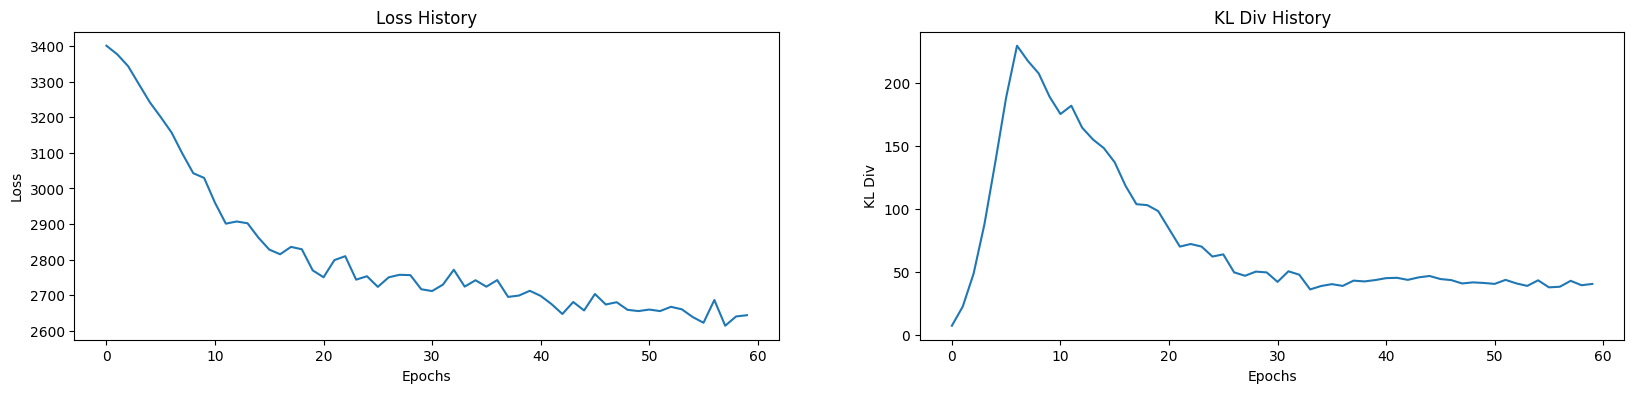

In [23]:
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)

plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss History")

plt.subplot(1,2,2)
plt.plot(kl_div_history)
plt.xlabel("Epochs")
plt.ylabel("KL Div")
plt.title("KL Div History")

plt.show()

# Show Original and Reconstructed Image

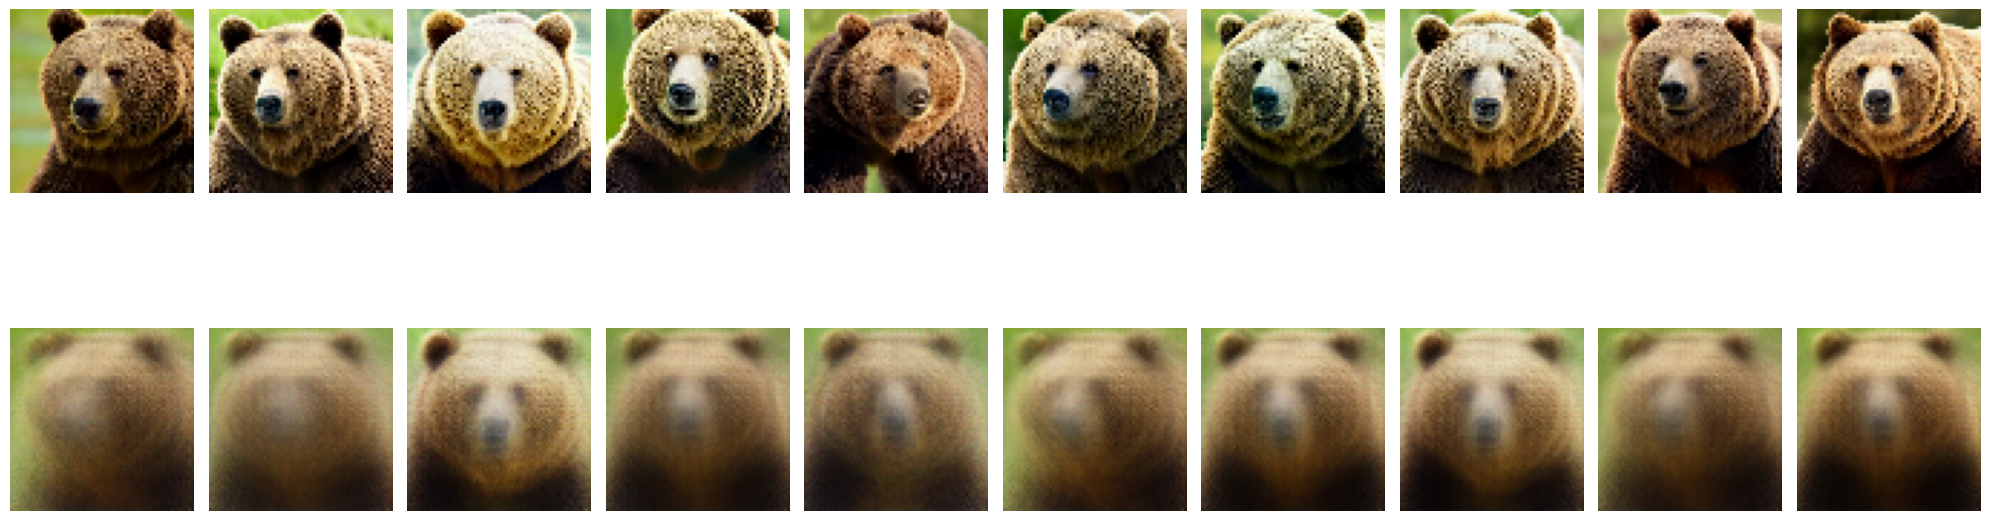

In [24]:
mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)

out = model.decode(z)
out = tf.reshape(out, [-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]]).numpy() * 255
out = out.astype(np.uint8)

number = 10
plt.figure(figsize=(20, 8))

for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(64, 64, 3))
    ax.axis("off")

for index in range(number):
    ax = plt.subplot(2, number, number + index + 1)
    plt.imshow(out[index])
    ax.axis("off")

plt.tight_layout()
plt.show()